# Homework 4

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображении, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершит предобработку картинки, описанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер и равномерно занимало место, то есть, если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в папке whale_tail/images к этому занятию. Разметка картинок (маски хвостов) лежат в папке whale_tail/ground_truth. После выделения хвоста посчитайте IoU для каждой картинки (ипсользуя маски из whale_tail/ground_truth)

<table><tr>
    <td> <img src="whale_tail/images/test_image_01.jpg" alt="Drawing" style="width: 400px;"/> 
    <td> <img src="whale_tail/ground_truth/test_image_01.png" alt="Drawing" style="width: 400px;"/> </td>
  
</tr></table>

# IoU 
 Intercetion over union - число от 0 до 1, показывающее, насколько у двух объектов (эталонного (ground true) и текущего) совпадает внутренний “объем”.
 
<table><tr>
    <td> <img src="../img/iou.png" alt="Drawing" style="width: 400px;"/> 
  
</tr></table>

In [17]:
import os
import cv2
import numpy as np
from skimage import transform
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [18]:
class WhaleProcessor:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size

    def _preprocess_mask(self, mask):
        """Предобработка маски для улучшения качества"""
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        return mask

    def _extract_tail_region(self, image, mask):
        """Извлечение области хвоста"""
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return None, None
        
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        tail_region = image[y:y+h, x:x+w]
        tail_mask = mask[y:y+h, x:x+w]
        
        return tail_region, tail_mask

    def _align_and_normalize(self, tail_region, tail_mask):
        """Выравнивание и нормализация хвоста"""
        # Определение угла поворота
        moments = cv2.moments(tail_mask)
        if moments['m00'] == 0:
            return None, None
        
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        
        # Вычисление главных осей
        eigenvalues, eigenvectors = np.linalg.eig(np.cov(np.where(tail_mask > 0)))
        angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
        
        # Поворот изображения
        M = cv2.getRotationMatrix2D((cx, cy), angle, 1)
        rotated_region = cv2.warpAffine(tail_region, M, (tail_region.shape[1], tail_region.shape[0]))
        rotated_mask = cv2.warpAffine(tail_mask, M, (tail_mask.shape[1], tail_mask.shape[0]))
        
        # Ресайз
        normalized_tail = cv2.resize(rotated_region, self.target_size)
        normalized_mask = cv2.resize(rotated_mask, self.target_size)
        
        return normalized_tail, normalized_mask

    def _compute_iou(self, mask1, mask2):
        """Вычисление IoU"""
        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        
        return np.sum(intersection) / np.sum(union)

    def process_images(self, images_dir, masks_dir):
        """Основной метод обработки изображений"""
        results = {}
        
        for filename in os.listdir(images_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(images_dir, filename)
                mask_path = os.path.join(masks_dir, filename.replace('.jpg', '.png'))
                
                # Загрузка изображения и маски
                image = cv2.imread(image_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                # Предобработка маски
                processed_mask = self._preprocess_mask(mask)
                
                # Извлечение региона хвоста
                tail_region, tail_mask = self._extract_tail_region(image, processed_mask)
                
                if tail_region is not None:
                    # Выравнивание и нормализация
                    normalized_tail, normalized_mask = self._align_and_normalize(tail_region, tail_mask)
                    
                    # Вычисление IoU
                    resized_mask = cv2.resize(mask, self.target_size)
                    iou = self._compute_iou(resized_mask > 0, normalized_mask > 0)
                    
                    results[filename] = {
                        'original_image': image,
                        'original_mask': mask,
                        'normalized_tail': normalized_tail,
                        'normalized_mask': normalized_mask,
                        'iou': iou
                    }
        
        return results

    def visualize_results(self, results):
        """Визуализация результатов обработки"""
        num_images = len(results)
        fig, axes = plt.subplots(num_images, 4, figsize=(20, 5*num_images))
        
        for i, (filename, data) in enumerate(results.items()):
            # Оригинальное изображение
            axes[i, 0].imshow(cv2.cvtColor(data['original_image'], cv2.COLOR_BGR2RGB))
            axes[i, 0].set_title(f'Original Image\n{filename}')
            axes[i, 0].axis('off')
            
            # Оригинальная маска
            axes[i, 1].imshow(data['original_mask'], cmap='gray')
            axes[i, 1].set_title('Original Mask')
            axes[i, 1].axis('off')
            
            # Нормализованный хвост
            axes[i, 2].imshow(cv2.cvtColor(data['normalized_tail'], cv2.COLOR_BGR2RGB))
            axes[i, 2].set_title(f'Normalized Tail\nIoU: {data["iou"]:.4f}')
            axes[i, 2].axis('off')
            
            # Нормализованная маска
            axes[i, 3].imshow(data['normalized_mask'], cmap='gray')
            axes[i, 3].set_title('Normalized Mask')
            axes[i, 3].axis('off')
        
        plt.tight_layout()
        plt.show()

In [19]:
def main():
    images_dir = 'whale_tail/images'
    masks_dir = 'whale_tail/ground_truth'
    processor = WhaleProcessor()
    results = processor.process_images(images_dir, masks_dir)
    for filename, data in results.items():
        print(f"{filename}: IoU = {data['iou']:.4f}")
    processor.visualize_results(results)

test_image_00.jpg: IoU = 0.2960
test_image_01.jpg: IoU = 0.3656
test_image_02.jpg: IoU = 0.3685
test_image_03.jpg: IoU = 0.3342
test_image_08.jpg: IoU = 0.3019
test_image_10.jpg: IoU = 0.3371


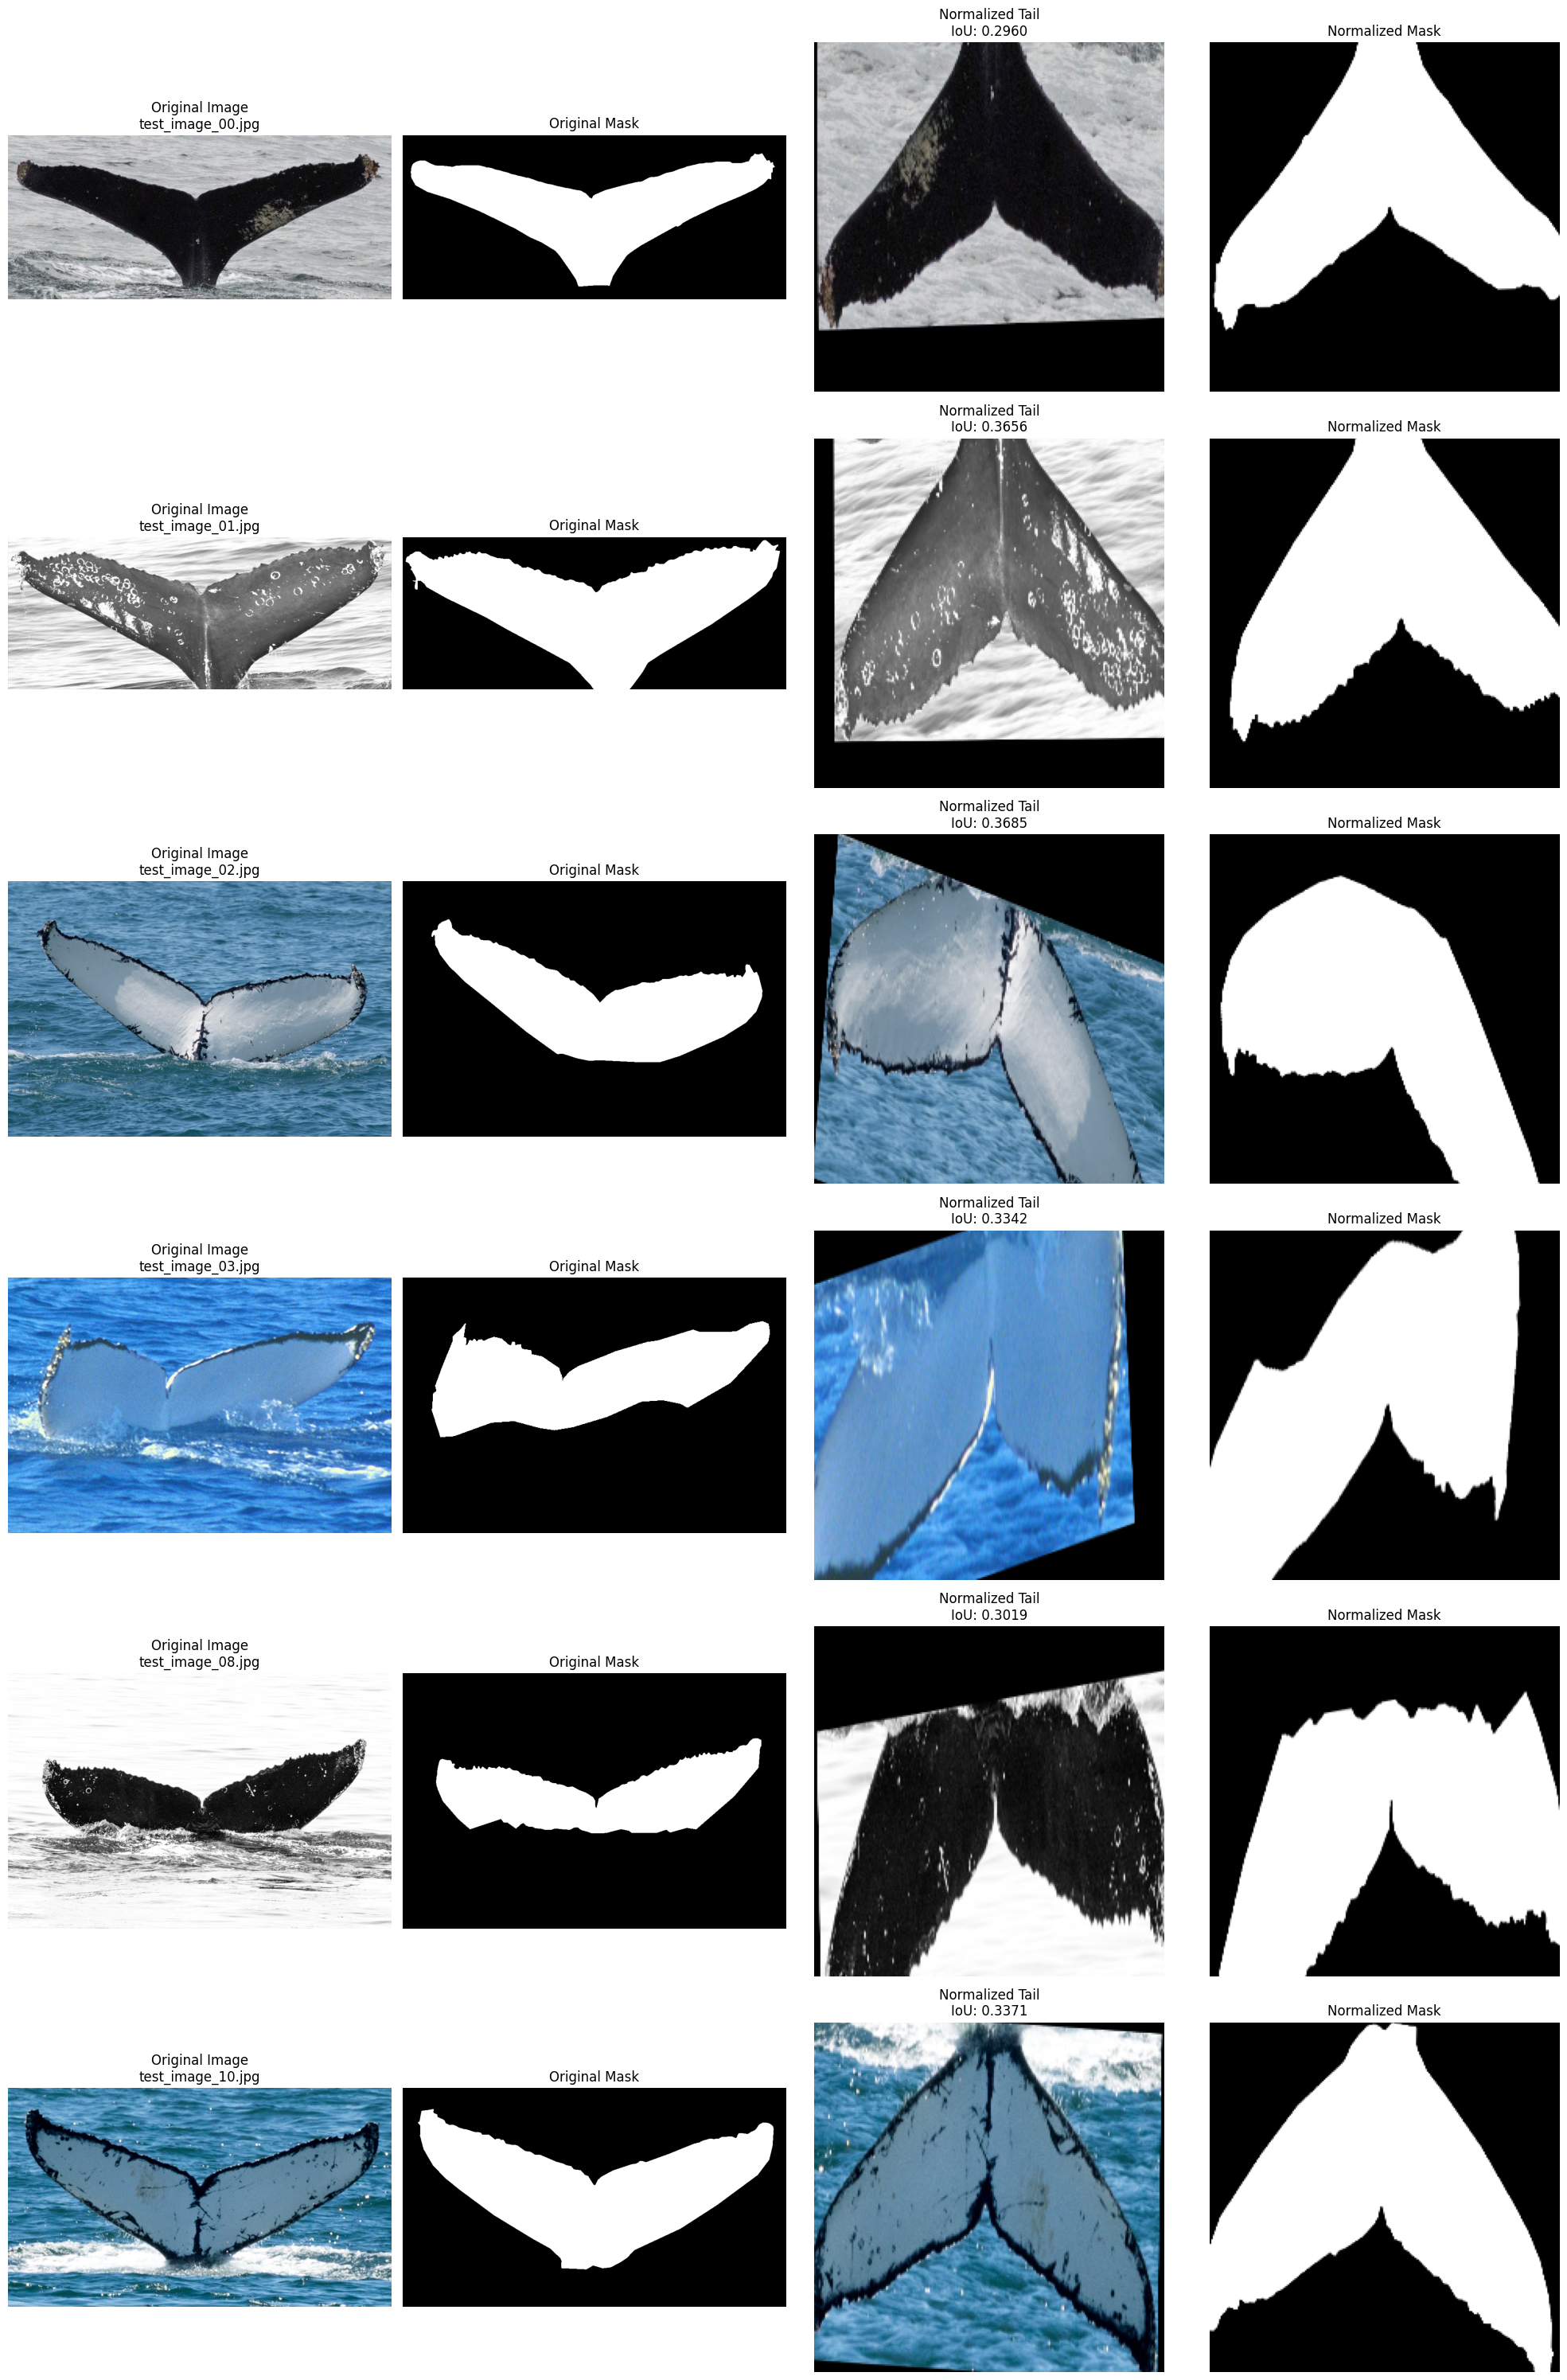

In [20]:
if __name__ == "__main__":
    main()

# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции 

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> 
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

In [21]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt


In [22]:
def compute_hog(image):
    """
    Вычисление HOG-дескриптора для изображения
    """
    # Преобразование изображения в оттенки серого
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Вычисление HOG
    hog_features, hog_image = hog(gray, 
                                  orientations=9, 
                                  pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), 
                                  visualize=True)
    
    # Нормализация изображения HOG
    hog_image = exposure.rescale_intensity(hog_image, out_range=(0, 255))
    
    return hog_features, hog_image.astype(np.uint8)

def find_template_by_cross_correlation(image, template):
    """
    Поиск шаблона методом кросс-корреляции
    """
    # Вычисление кросс-корреляции
    result = cv2.matchTemplate(image, template, cv2.TM_CCORR_NORMED)
    
    # Поиск максимального совпадения
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    return max_loc, max_val



In [23]:
def main():
    # Загрузка шаблона глаза
    template_orig = cv2.imread('hog/eye.png')
    
    # Список изображений для поиска
    image_paths = [
        'hog/eyes.jpg',
        'hog/eyes_dark.jpg', 
        'hog/woman.jpg'
    ]
    
    # Вычисление HOG для шаблона
    template_hog_features, template_hog_image = compute_hog(template_orig)
    
    # Обработка каждого изображения
    for path in image_paths:
        # Загрузка изображения
        image_orig = cv2.imread(path)
        
        # Вычисление HOG для изображения
        image_hog_features, image_hog_image = compute_hog(image_orig)
        
        # Поиск шаблона методом кросс-корреляции в HOG-изображении
        top_left, confidence = find_template_by_cross_correlation(image_hog_image, template_hog_image)
        
        # Получение размеров шаблона
        h, w = template_hog_image.shape[:2]
        
        # Отрисовка прямоугольника на оригинальном изображении
        cv2.rectangle(image_orig, 
                      top_left, 
                      (top_left[0] + w, top_left[1] + h), 
                      (0, 255, 0), 
                      2)
        
        # Создание subplot для визуализации
        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.title('Оригинальное изображение')
        plt.imshow(cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB))
        
        plt.subplot(132)
        plt.title('HOG шаблон')
        plt.imshow(template_hog_image, cmap='gray')
        
        plt.subplot(133)
        plt.title('HOG изображения')
        plt.imshow(image_hog_image, cmap='gray')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Изображение {path}")
        print(f"Координаты шаблона: {top_left}")
        print(f"Уверенность совпадения: {confidence}\n")


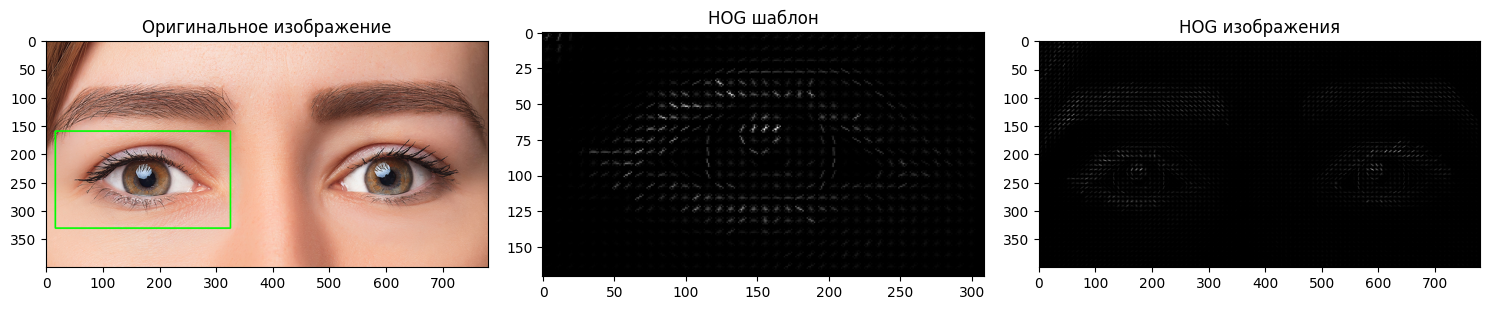

Изображение hog/eyes.jpg
Координаты шаблона: (16, 160)
Уверенность совпадения: 0.9437423944473267



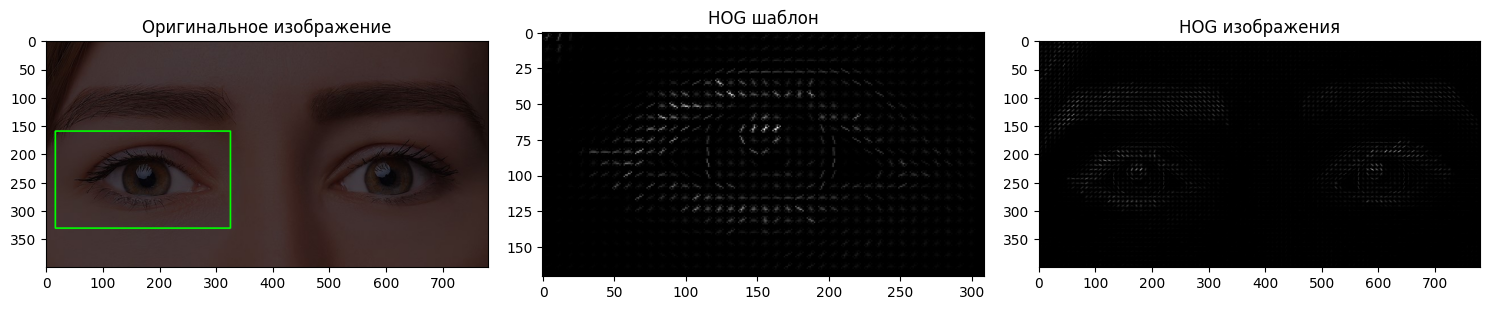

Изображение hog/eyes_dark.jpg
Координаты шаблона: (16, 160)
Уверенность совпадения: 0.9312105178833008



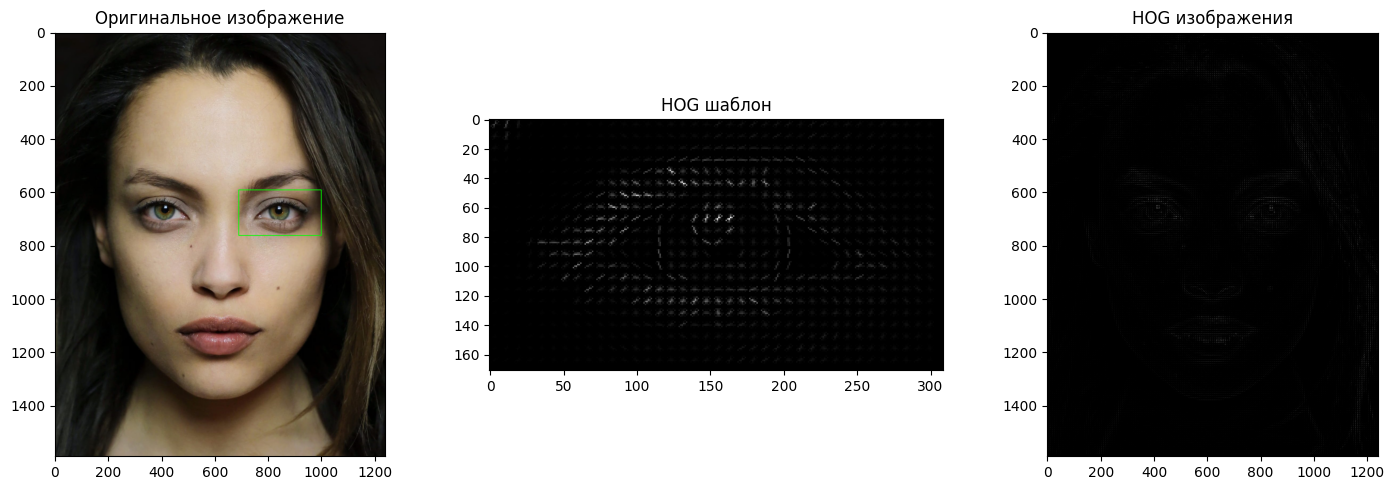

Изображение hog/woman.jpg
Координаты шаблона: (688, 592)
Уверенность совпадения: 0.599327564239502



In [24]:

if __name__ == "__main__":
    main()